# Example application of the extended Kalman filter to the Van der Pol oscillator


This notebook demonstrates the application of the extended Kalman filter to the [Van der Pol oscillator](https://en.wikipedia.org/wiki/Van_der_Pol_oscillator).

### <font color='289C4E'>Table of contents<font><a class='anchor' id='top'></a>

1. [Creating synthetic data](#synthetic)

1. [Running the EKF](#ekf)



---

## 1. Creating synthetic data <a name="synthetic"></a>

We consider the following system

* States $\mathbf{x} = (x,y)$

* Observations $\mathbf{z} = z$

with 

$$\dot{x} = y + \epsilon_{\rm p}$$

$$\dot{y} = \mu(1-x^2)y - x$$

$$z = xy + \epsilon_{\rm m} $$

where $\epsilon_{\rm p}$ is a mean-zero Gaussian process noise, with covariance $\sigma_{\rm p}^2$, and $\epsilon_{\rm m}$ is a mean-zero Gaussian measurement noise, with covariance $\sigma_{\rm m}^2$


This is the second order Van der Pol oscillator recast as a pair of first order ODEs, with some process noise added. The observation $z$ is arbitrarily chosen to be a product of the states.

In [14]:
import numpy as np 
import matplotlib.pyplot as plt 
import scienceplots
plt.style.use('science')

class VanDerPol:
    """ Simulates the signal from a Van der Pol oscillator with process noise. 
    
    The observation is an arbitrary, non-linear combination of the states
    """
    
    def __init__(self,μ,σp,σm, x, y,seed):
    
        self.μ  = μ
        self.σp = σp 
        self.σm = σm
        self.x  = x
        self.y  = y
        self.generator = np.random.default_rng(seed)



        
    def take_a_timestep(self):
        """ Call once for each new measurement at dt time from last call.
            Uses a basic Euler method.
        """
        

        dx = self.y + self.generator.normal(0, self.σp) #add some process noise to dx
        dy = self.μ*(1-self.x**2)*self.y - self.x 

        self.x = self.x  + self.dt*dx 
        self.y = self.y  + self.dt*dy
        
        #observation = self.x*self.y + self.generator.normal(0, self.σm) 
        observation = self.x**2*self.y +self.y + self.generator.normal(0, self.σm) 

        return self.x,self.y,observation



    def integrate(self,dt,n_steps):
        """ Integrate for n_steps timesteps and return an array that holds the states and observations
        """

        self.dt = dt
        self.n_steps   = n_steps

        self.t            = np.arange(0,self.n_steps*self.dt,self.dt)
        self.output_array = np.zeros((self.n_steps,3)) 

        for i in range(self.n_steps):
            self.output_array[i,:] = VDP.take_a_timestep()



    def plot_phase_space(self):
        """
        A plotting function which plots the evolution in the x-y phase plane
        """


        #Setup the figure
        h,w = 6,6
        rows = 1
        cols = 1
        fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(h,w),sharex=True)
    
        x = self.output_array[:,0]
        y = self.output_array[:,1]
        ax.plot(x,y)
        

        #Clean up axes
        fs=20
        ax.set_xlabel('x', fontsize=fs)
        ax.set_ylabel('y', fontsize=fs)
        ax.xaxis.set_tick_params(labelsize=fs-4)
        ax.yaxis.set_tick_params(labelsize=fs-4)


    def plot_timeseries(self,prediction_data=None):
        """
        A plotting function which plots the states/observations as a function of time
        """


        #Setup the figure
        h,w =8,8
        rows = 3
        cols = 1
        fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(h,w),sharex=True)


        data_label = 'data'
        for i in range(len(axes)):
            axes[i].plot(self.t,self.output_array[:,i],label=data_label)
 

        if prediction_data is not None:
            states = prediction_data[0]
            measurements = prediction_data[1]

            
            prediction_color = 'C2'
            prediction_label = 'prediction'
            axes[0].plot(self.t,states[:,0],c=prediction_color,label=prediction_label)
            axes[1].plot(self.t,states[:,1],c=prediction_color,label=prediction_label)
            
            axes[2].plot(self.t,measurements[:,0],c=prediction_color,label=prediction_label)

            plt.legend(fontsize=12)

        
    
        #Clean up axes
        fs=20
        axes[2].set_xlabel('t', fontsize=fs)

        axes[0].set_ylabel('x', fontsize=fs)
        axes[1].set_ylabel('y', fontsize=fs)
        axes[2].set_ylabel('z', fontsize=fs)

        plt.subplots_adjust(hspace=0.0)

        for ax in axes:
            ax.xaxis.set_tick_params(labelsize=fs-4)
            ax.yaxis.set_tick_params(labelsize=fs-4)

        # ax.legend(prop={'size':fs})



Lets take a quick look at the data

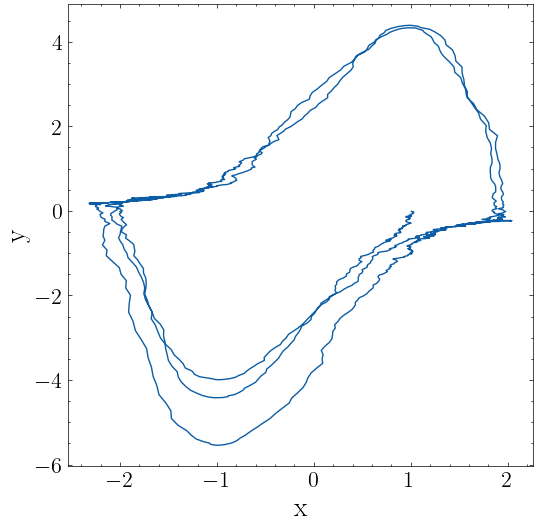

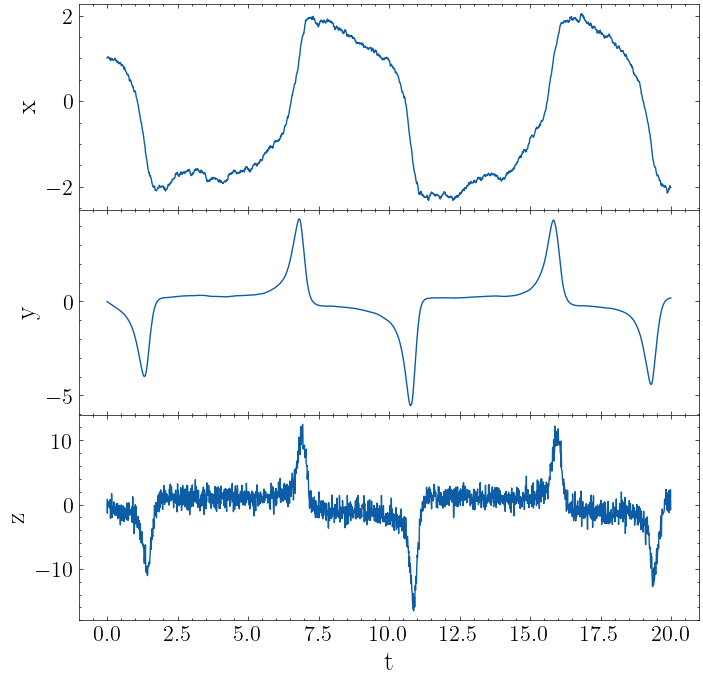

In [15]:
#Parameters of the system
μ    = 3.0
σp   = 2.0
σm   = 1.0
x0   = 1.0
y0   = .0
seed = 1

#Initialise the class
VDP = VanDerPol(μ,σp,σm, x0, y0,seed)

#Integrate
VDP.integrate(dt=0.01,n_steps=2000)

#Plot
VDP.plot_phase_space()
VDP.plot_timeseries()

We can also turn off the process noise, e.g. 

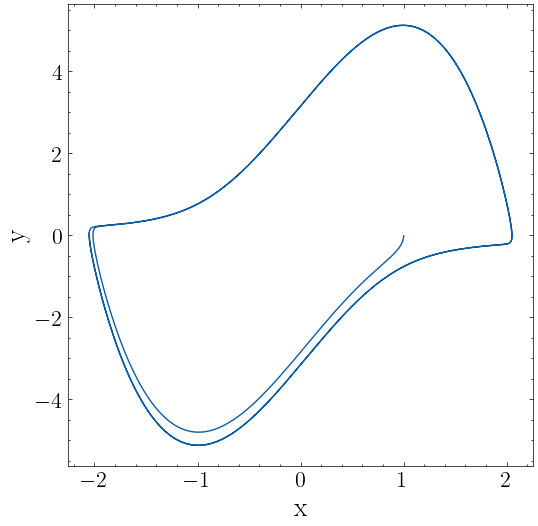

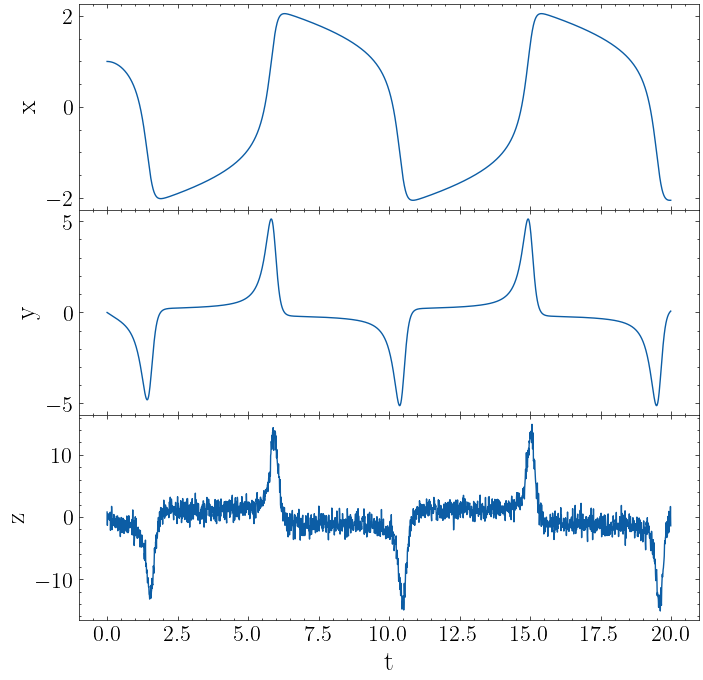

In [16]:
#Initialise the class
VDP = VanDerPol(μ,0.0,σm, x0, y0,seed)

#Integrate
VDP.integrate(dt=0.01,n_steps=2000)

#Plot
VDP.plot_phase_space()
VDP.plot_timeseries()

...and vary the damping constant 

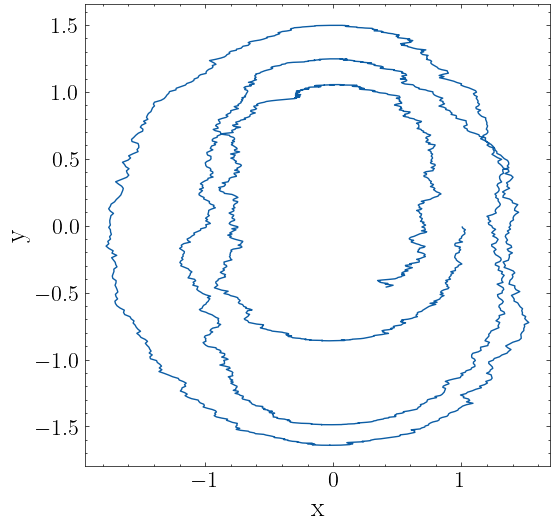

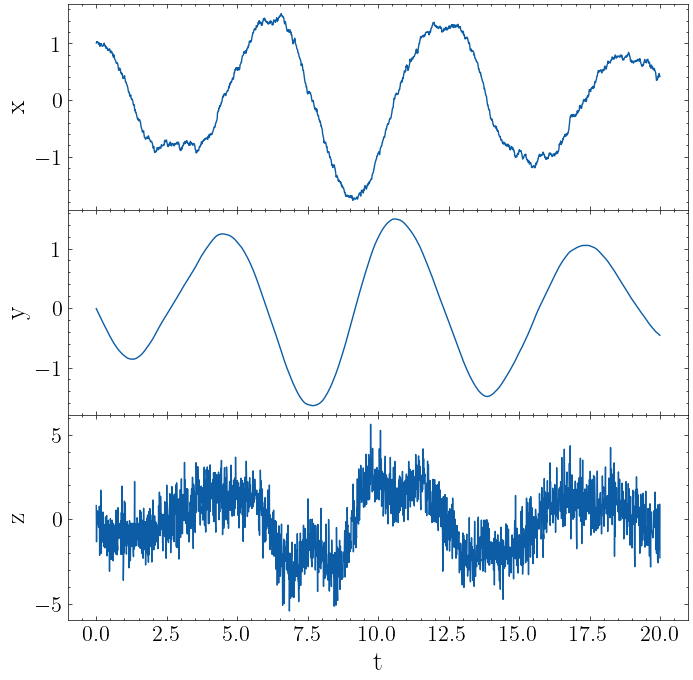

In [17]:
#Initialise the class
VDP = VanDerPol(0.01,σp,σm, x0, y0,seed)

#Integrate
VDP.integrate(dt=0.01,n_steps=2000)

#Plot
VDP.plot_phase_space()
VDP.plot_timeseries()

## 2. Mathematics of the Extended Kalman filter


A reccomended resource for extended Kalman filtering is Chapter 7 of ["Fundamentals of Kalman Filtering: A Practical Approach"](https://arc.aiaa.org/doi/book/10.2514/4.102776)


In summary 

* $\mathbf{\dot{x}} = f(\mathbf{x}) + \mathbf{w}$ 

* $\mathbf{z} = h(\mathbf{x}) + \mathbf{v} $

* $\mathbf{w} \sim \mathcal{N}(0,\mathbf{\Sigma}_p)$, $\mathbf{v} \sim \mathcal{N}(0,\mathbf{\Sigma}_m)$

* $\mathbf{F} = \frac{\partial f(\mathbf{x})}{\partial \mathbf{x}}$
* $\mathbf{H} = \frac{\partial h(\mathbf{x})}{\partial \mathbf{x}}$
* $\mathbf{Q} = E(\mathbf{w} \mathbf{w}^{T})$

### 2.1 Mathematics of the Van der Pol EKF


In order to deploy the the extended Kalman filter we need to specify all the Kalman "machinery", i.e. the various model-specific functions and matrices.

The machinery for the VDP model is as follows:


* States $\mathbf{x} = (x,y)$
* State transition function $f(\mathbf{x}) =\begin{bmatrix}
           y \\
           \mu(1-x^2)y - x\\
         \end{bmatrix}$ 

* Observation function $h(\mathbf{x}) = xy$

* State Jacobian $F = \frac{\partial f}{\partial \mathbf{x}} =\begin{pmatrix}
           0 & 1 \\
           -2\mu x y -1 & \mu (1-x^2)\\
         \end{pmatrix}$

* Measurement Jacobian $H = \frac{\partial h}{\partial \mathbf{x}} = \begin{pmatrix}
           y  \\
           x\\
         \end{pmatrix}$

* Fundamental matrix $\mathbf{\Phi}(t) = \mathbf{I} + \mathbf{F} t$

* Discretised Q-matrix $\mathbf{Q} = \int_0^{T_s} \mathbf{\Phi}(t) \mathbf{Q} \mathbf{\Phi}^T(t) dt = \sigma_p^2 T_s\begin{pmatrix} 1 & T_s F_{21}/2 \\ T_s F_{21}/2  & T_s^2 F_{21}^2 / 3  \end{pmatrix}$ 
  * where $F_{21} = -2\mu x y -1$


* R-matrix $\mathbf{R} = \sigma_{\rm m}^2$


The above is implemented in `model.py`(todo implement this as a meta-class, allow used defined models)



## 3. Running the EKF 


We are now in a position to run the EKF on our synthetic data

#### 3.1 Setup 

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import sys
sys.path.append("../src") # add src to path so it can be accessed here 

#### 3.2 Generate data 

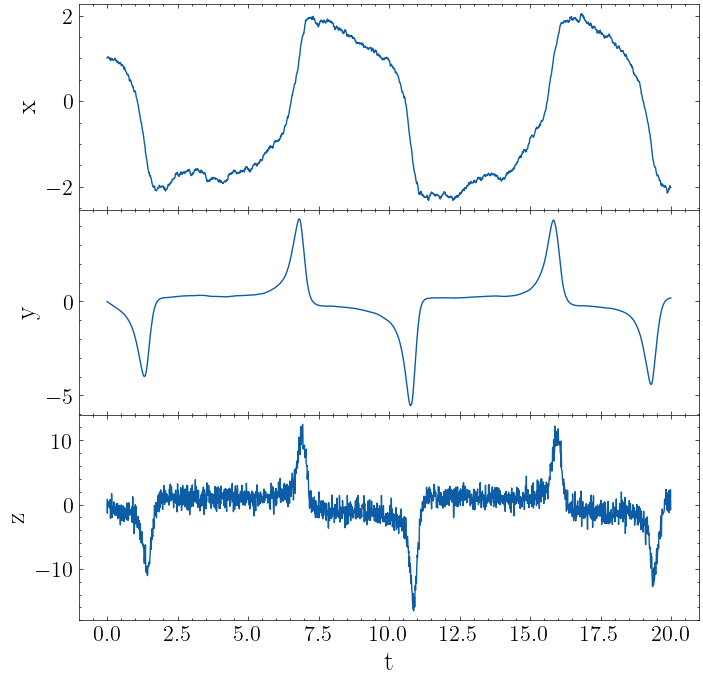

In [42]:
#Parameters of the system
μ    = 3.0
σp   = 2.0
σm   = 1.0
x0   = 1.0
y0   = 0.0
seed = 1
dt   = 0.01
n_steps = 2000

#Initialise the class
VDP = VanDerPol(μ,σp,σm, x0, y0,seed)

#Integrate
VDP.integrate(dt=dt,n_steps=n_steps)

#Plot
VDP.plot_timeseries()

#### 3.3 Run the filter 

In [44]:
from model import KalmanVDP
from kalman_filter import ExtendedKalmanFilter
from priors import bilby_priors_dict


In [45]:
#Define the model
model = KalmanVDP(dt=dt)

#Setup the filter
x_guess = np.array(([x0,y0])) #guess of the initial states. set equal to true values for now. Obv we don't know this in practice/ todo


data = VDP.output_array[:,2] # these are the actual observations 
P0 = 0.0*np.array(([1.0,0.0],[0.0,1.0]))
KF = ExtendedKalmanFilter(model,data.reshape(len(data),1),x_guess,P0)

#Set the system parameters :: we use bilby keeping an eye on when we will be using this in conjunction with e.g. nested sampling
init_parameters,parameters_dict = bilby_priors_dict(μ,σp,σm)
parameters = parameters_dict.sample()
parameters['σp'] = parameters['σp']

#Run the filter
KF.run(parameters)

P =  [[0. 0.]
 [0. 0.]]
H =  [[0. 2.]]
S =  [[1.]]
----------------
P =  [[ 4.00000000e-02 -2.00000000e-04]
 [-2.00000000e-04  1.33333333e-06]]
H =  [[-0.02  2.  ]]
S =  [[1.00003733]]
----------------
P =  [[ 4.00013333e-02 -2.02364894e-08]
 [-2.02364894e-08  3.53291652e-02]]
H =  [[-0.04010712  2.00297911]]
S =  [[1.14180232]]
----------------
P =  [[ 0.07094357 -0.00047644]
 [-0.00047644  0.04306938]]
H =  [[-0.0074939   2.00191103]]
S =  [[1.1726252]]
----------------
P =  [[0.07672917 0.0001316 ]
 [0.0001316  0.10230597]]
H =  [[0.04696124 2.00129777]]
S =  [[1.40994909]]
----------------
P =  [[ 0.11257233 -0.00016266]
 [-0.00016266  0.12292857]]
H =  [[0.06859701 2.0029702 ]]
S =  [[1.49366089]]
----------------
P =  [[1.22343785e-01 2.39790083e-04]
 [2.39790083e-04 2.72626376e-01]]
H =  [[0.16552136 2.00833262]]
S =  [[2.10312251]]
----------------
P =  [[0.17006384 0.004141  ]
 [0.004141   0.07006176]]
H =  [[-0.10086106  1.99820014]]
S =  [[1.27980374]]
----------------
P =  

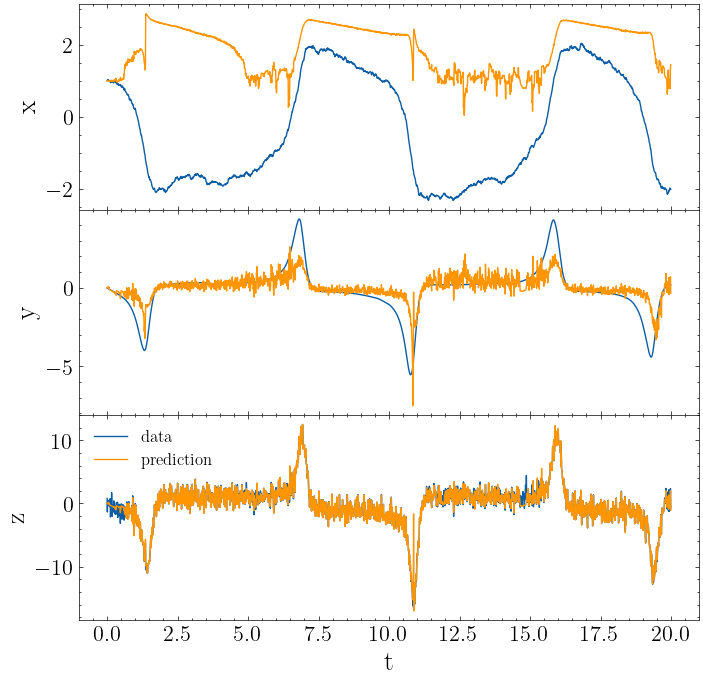

In [46]:
VDP.plot_timeseries(prediction_data=[KF.state_predictions,KF.measurement_predictions])

---


## Appendix A: Derivation of Q matrix 

* Q-matrix $\mathbf{Q} = \int_0^{\Delta t} \exp(F t) \begin{pmatrix} \sigma_{\rm p}^2 & 0 \\ 0 & 0\end{pmatrix} \exp(F^T t) dt$


$= \int_0^{\Delta t}\begin{pmatrix} 1+F_{11} t & F_{12}t \\ F_{21}t & 1+F_{22}\end{pmatrix} \begin{pmatrix} \sigma_{\rm p}^2 & 0 \\ 0 & 0\end{pmatrix} \begin{pmatrix} 1+F_{11} t & F_{21}t \\ F_{12}t & 1+F_{22}\end{pmatrix} dt $

$= \int_0^{\Delta t}\begin{pmatrix} 1+F_{11} t & F_{12}t \\ F_{21}t & 1+F_{22}\end{pmatrix} \begin{pmatrix} \sigma_{\rm p}^2(1+F_{11} t) & \sigma_{\rm p}^2 F_{21}t \\ 0 & 0\end{pmatrix}  dt $

$= \int_0^{\Delta t} \begin{pmatrix} \sigma_{\rm p}^2(1+F_{11} t)^2 & \sigma_{\rm p}^2 (1+F_{11} t) F_{21}t \\ \sigma_{\rm p}^2 (1+F_{11} t) F_{21}t & \sigma_{\rm p}^2 F_{21}^2 t^2\end{pmatrix}  dt $


where we have used $\exp(F t) \sim I + Ft$

The expression for $F_{11}$ is simple (=1) so we can sub that in. The expression for $F_{21}$ is more complicated, so we can leave that as is for now. 

$= \sigma_{\rm p}^2 \int_0^{\Delta t} \begin{pmatrix} (1+ t)^2 &  (1+ t) F_{21}t \\  (1+t) F_{21}t &  F_{21}^2 t^2\end{pmatrix}  dt $

$= \sigma_{\rm p}^2 \Delta t\begin{pmatrix} (1+ \Delta t + 1/3 \Delta t^2) &  (1/2 \Delta t + 1/3 \Delta t^2) F_{21} \\ (1/2 \Delta t + 1/3 \Delta t^2) F_{21}  &  1/3 \Delta t^2 F_{21}^2\end{pmatrix} $

